#  Example 4: Cation exchange- flushing of a sodium-potassium nitrate solution with calcium chloride
This modelling example is the first among several examples that include and demonstrate ion-exchanging reactions in flow-through systems. The example was originally used as PHREEQM (Nienhuis et al., 1994) test case, and is also included in the PHREEQC-3 documentation (Parkhurst and Appelo, 2013) as Example 11. Further discussion can be found in (Appelo and Postma, 1993), where it forms Example 10.13, and in (Appelo, 1994). The one-dimensional simulation problem describes a hypothetical column experiment where porewater containing sodium (Na<sup>+</sup>), potassium (K<sup>+</sup>) and nitrate (NO<sup>-</sup><sub>3</sub>) in equilibrium with exchangeable cations is flushed by a calcium chloride (CaCl<sub>2</sub>) solution

In [1]:
from pathlib import Path
import os
from modflowapi.extensions import ApiSimulation
from modflowapi import Callbacks
# from workflow import *
from datetime import datetime
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#add mf6rtm path to the system
sys.path.insert(0,os.path.join("..","..","mf6rtm"))
import flopy
import mf6rtm
import utils

import re
import difflib

prefix = 'ex4'
DT_FMT = "%Y-%m-%d %H:%M:%S"

#stuff to compare outputs from pht3d and mf6rtm

def find_closest_match(query, dictionary):
    closest_match = difflib.get_close_matches(query, dictionary.keys(), n=1)
    if closest_match:
        return closest_match[0]
    else:
        return None
    
def calc_rows_from_ncol(variables, ncols=4):
    '''
    Calculates number of rows for subplots
    from ncols and len of variables to plot.

    Parameters:
        variables (list or sequence): list of variables to plot
        ncols (int): number of columns to plot
    '''
    n_subplots = len(variables)
    # calculate number of rows
    nrows = n_subplots // ncols + (n_subplots % ncols > 0)
    return nrows

## Flow and Transport Setup

In [2]:
### Model params and setup

# General
length_units = "meters"
time_units = "days"

# Model discretization
nlay = 1  # Number of layers
Lx = 0.08 #m
ncol = 40 # Number of columns
nrow = 1  # Number of rows
delr = Lx/ncol #10.0  # Column width ($m$)
delc = 1.0  # Row width ($m$)
top = 1.  # Top of the model ($m$)
# botm = 0.0  # Layer bottom elevations ($m$)
zbotm = 0.
botm = np.linspace(top, zbotm, nlay + 1)[1:]

#tdis
nper = 1  # Number of periods
tstep = 0.002  # Time step ($days$)
perlen = 0.24  # Simulation time ($days$)
nstp = perlen/tstep #100.0
dt0 = perlen / nstp
tdis_rc = []
tdis_rc.append((perlen, nstp, 1.0))

#injection
q = 1 #injection rate m3/d
wel_spd = [[(0,0,0), q]]


#hydraulic properties
prsity = 1 # Porosity
k11 = 1.0  # Horizontal hydraulic conductivity ($m/d$)
k33 = k11  # Vertical hydraulic conductivity ($m/d$)
strt = np.ones((nlay, nrow, ncol), dtype=float)*1
# two chd one for tailings and conc and other one for hds 

# two chd one for tailings and conc and other one for hds 
r_hd = 1
strt = np.ones((nlay, nrow, ncol), dtype=float)

chdspd = [[(i, 0, ncol-1), r_hd] for i in range(nlay)] # Constant head boundary $m$
# chdspd.extend([(i, 0, ncol - 1), r_hd] for i in range(nlay))

# chdspd_tail = [[(i, 0, 0), l_hd] for i in range(0,3)]

#transport
dispersivity = 0.002 # Longitudinal dispersivity ($m$)
disp_tr_vert = dispersivity*0.1 # Transverse vertical dispersivity ($m$)


icelltype = 1  # Cell conversion type
# ibound = np.ones((nlay, nrow, ncol), dtype=int)
# ibound[:, 0, -1] = -1
# ibound[:, 0, 0] = -1

# Set solver parameter values (and related)
nouter, ninner = 300, 600
hclose, rclose, relax = 1e-6, 1e-6, 1.0

## Initialize Chemistry in Domain

In [3]:
dataws = os.path.join("..", "data")

files = [f for f in os.listdir(dataws) if f.startswith(prefix)]

solutionsdf = pd.read_csv(os.path.join(dataws,f"{prefix}_solutions.csv"), comment = '#',  index_col = 0)

# solutions = utils.solution_csv_to_dict(os.path.join(dataws,f"{prefix}_solutions.csv"))
solutions = utils.solution_df_to_dict(solutionsdf)



In [4]:
#assign solutions to grid
sol_ic = np.ones((nlay, nrow, ncol), dtype=float)
# sol_ic = 1
#add solutions to clss
solution = mf6rtm.Solutions(solutions)
solution.set_ic(sol_ic)

excdf = pd.read_csv(os.path.join(dataws,f"{prefix}_exchange.csv"), comment = '#',  index_col = 0)
exchangerdic = utils.solution_df_to_dict(excdf)

exchanger = mf6rtm.ExchangePhases(exchangerdic)
exchanger.set_ic(np.ones((nlay, nrow, ncol), dtype=float))

#create model class
model = mf6rtm.Mup3d(prefix,solution, nlay, nrow, ncol)

#set model workspace
model.set_wd(os.path.join(f'mf6rtm'))

#set database
database = os.path.join('..', 'database', f'pht3d_datab.dat')
model.set_database(database)

model.set_exchange_phases(exchanger)

#get postfix file
postfix = os.path.join(dataws, f'{prefix}_postfix.phqr')
model.set_postfix(postfix)
#get phreeqc input
# phinp = model.generate_phreeqc_script(postfix =  postfix)

In [5]:
model.initialize()

CaX2 0.0
NaX 0.0005493
KX 0.0005507
Phreeqc initialized


## Initialize Inflow Chemistry

In [6]:
wellchem = mf6rtm.ChemStress('wel')
sol_spd = [2]
sol_spd
wellchem.set_spd(sol_spd)
model.set_chem_stress(wellchem)
model.wel.data

Initializing ChemStress
ChemStress wel initialized


{0: [110684.17114503866,
  55342.08558975302,
  -1.3109877641849824e-06,
  0.5982258070710699,
  1.1964516141421357,
  0.0,
  0.0,
  0.0]}

In [7]:
for i in range(len(wel_spd)):
    wel_spd[i].extend(model.wel.data[i])
print(wel_spd)

[[(0, 0, 0), 1, 110684.17114503866, 55342.08558975302, -1.3109877641849824e-06, 0.5982258070710699, 1.1964516141421357, 0.0, 0.0, 0.0]]


## Build MF6 Model

In [8]:
def build_model(mup3d):

    #####################        GWF model           #####################
    gwfname = 'gwf'
    sim_ws = mup3d.wd
    sim = flopy.mf6.MFSimulation(sim_name=mup3d.name, sim_ws=sim_ws, exe_name='mf6')

    # Instantiating MODFLOW 6 time discretization
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_rc, time_units=time_units)

    # Instantiating MODFLOW 6 groundwater flow model
    gwf = flopy.mf6.ModflowGwf(
        sim,
        modelname=gwfname,
        save_flows=True,
        model_nam_file=f"{gwfname}.nam",
    )

    # Instantiating MODFLOW 6 solver for flow model
    imsgwf = flopy.mf6.ModflowIms(
        sim,
        complexity="complex",
        print_option="SUMMARY",
        outer_dvclose=hclose,
        outer_maximum=nouter,
        under_relaxation="NONE",
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=rclose,
        linear_acceleration="CG",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=relax,
        filename=f"{gwfname}.ims",
    )
    sim.register_ims_package(imsgwf, [gwf.name])

    # Instantiating MODFLOW 6 discretization package
    dis = flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        idomain=np.ones((nlay, nrow, ncol), dtype=int),
        filename=f"{gwfname}.dis",
    )
    dis.set_all_data_external()

    # Instantiating MODFLOW 6 node-property flow package
    npf = flopy.mf6.ModflowGwfnpf(
        gwf,
        save_flows=True,
        save_saturation = True,
        icelltype=icelltype,
        k=k11,
        k33=k33,
        save_specific_discharge=True,
        filename=f"{gwfname}.npf",
    )
    npf.set_all_data_external()
    # sto = flopy.mf6.ModflowGwfsto(gwf, ss=1e-6, sy=0.25)

    # Instantiating MODFLOW 6 initial conditions package for flow model
    flopy.mf6.ModflowGwfic(gwf, strt=strt, filename=f"{gwfname}.ic")
    
    wel = flopy.mf6.ModflowGwfwel(
            gwf,
            stress_period_data=wel_spd,
            save_flows = True,
            auxiliary = model.components,
            pname = 'wel',
            filename=f"{gwfname}.wel"
        )
    wel.set_all_data_external()

    # Instantiating MODFLOW 6 constant head package
    chd = flopy.mf6.ModflowGwfchd(
        gwf,
        maxbound=len(chdspd),
        stress_period_data=chdspd,
        # auxiliary=mup3d.components,
        save_flows=False,
        pname="CHD",
        filename=f"{gwfname}.chd",
    )
    chd.set_all_data_external()

    # Instantiating MODFLOW 6 output control package for flow model
    oc_gwf = flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=f"{gwfname}.hds",
        budget_filerecord=f"{gwfname}.cbb",
        headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
        printrecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
    )
    
    #####################           GWT model          #####################
    for c in mup3d.components:
        print(f'Setting model for component: {c}')
        gwtname = c
        
        # Instantiating MODFLOW 6 groundwater transport package
        gwt = flopy.mf6.MFModel(
            sim,
            model_type="gwt6",
            modelname=gwtname,
            model_nam_file=f"{gwtname}.nam"
        )

        # create iterative model solution and register the gwt model with it
        print('--- Building IMS package ---')
        imsgwt = flopy.mf6.ModflowIms(
            sim,
            print_option="SUMMARY",
            outer_dvclose=hclose,
            outer_maximum=nouter,
            under_relaxation="NONE",
            inner_maximum=ninner,
            inner_dvclose=hclose,
            rcloserecord=rclose,
            linear_acceleration="BICGSTAB",
            scaling_method="NONE",
            reordering_method="NONE",
            relaxation_factor=relax,
            filename=f"{gwtname}.ims",
        )
        sim.register_ims_package(imsgwt, [gwt.name])

        print('--- Building DIS package ---')
        dis = gwf.dis

        # create grid object
        dis = flopy.mf6.ModflowGwtdis(
            gwt,
            length_units=length_units,
            nlay=nlay,
            nrow=nrow,
            ncol=ncol,
            delr=delr,
            delc=delc,
            top=top,
            botm=botm,
            idomain=np.ones((nlay, nrow, ncol), dtype=int),
            filename=f"{gwtname}.dis",
        )
        dis.set_all_data_external()

         
        ic = flopy.mf6.ModflowGwtic(gwt, strt=mup3d.sconc[c], filename=f"{gwtname}.ic")
        ic.set_all_data_external()
        
        # Instantiating MODFLOW 6 transport source-sink mixing package
        sourcerecarray = ['wel', 'aux', f'{c}']
        # sourcerecarray = [()]
        ssm = flopy.mf6.ModflowGwtssm(
            gwt, 
            sources=sourcerecarray, 
            save_flows=True,
            print_flows=True,

            filename=f"{gwtname}.ssm"
        )
        ssm.set_all_data_external()
        # Instantiating MODFLOW 6 transport adv package
        print('--- Building ADV package ---')
        adv = flopy.mf6.ModflowGwtadv(
            gwt,
            scheme="tvd",
        )

        # Instantiating MODFLOW 6 transport dispersion package
        alpha_l = np.ones(shape=(nlay, nrow, ncol))*dispersivity  # Longitudinal dispersivity ($m$)
        ath1 = np.ones(shape=(nlay, nrow, ncol))*dispersivity*0.1 # Transverse horizontal dispersivity ($m$)
        atv = np.ones(shape=(nlay, nrow, ncol))*dispersivity*0.1   # Transverse vertical dispersivity ($m$)

        print('--- Building DSP package ---')
        dsp = flopy.mf6.ModflowGwtdsp(
            gwt,
            xt3d_off=True,
            alh=alpha_l,
            ath1=ath1,
            atv = atv,
            # diffc = diffc,
            filename=f"{gwtname}.dsp",
        )
        dsp.set_all_data_external()

        # Instantiating MODFLOW 6 transport mass storage package (formerly "reaction" package in MT3DMS)
        print('--- Building MST package ---')

        first_order_decay = None

        mst = flopy.mf6.ModflowGwtmst(
            gwt,
            porosity=prsity,
            first_order_decay=first_order_decay,
            filename=f"{gwtname}.mst",
        )
        mst.set_all_data_external()

        print('--- Building OC package ---')

        # Instantiating MODFLOW 6 transport output control package
        oc_gwt = flopy.mf6.ModflowGwtoc(
            gwt,
            budget_filerecord=f"{gwtname}.cbb",
            concentration_filerecord=f"{gwtname}.ucn",
            concentrationprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 10, "GENERAL")
                                        ],
            saverecord=[("CONCENTRATION", "ALL"), 
                        ("BUDGET", "ALL")
                        ],
            printrecord=[("CONCENTRATION", "ALL"), 
                            ("BUDGET", "ALL")
                            ],
        )

        # Instantiating MODFLOW 6 flow-transport exchange mechanism
        flopy.mf6.ModflowGwfgwt(
            sim,
            exgtype="GWF6-GWT6",
            exgmnamea=gwfname,
            exgmnameb=gwtname,
            filename=f"{gwtname}.gwfgwt",
        )

    sim.write_simulation()
    utils.prep_bins(sim_ws, src_path=os.path.join('..','bin'))
    
    return sim

In [9]:
sim = build_model(model)

Setting model for component: H
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
Setting model for component: O
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
Setting model for component: Charge
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
Setting model for component: Ca
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
Setting model for component: Cl
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
-

In [10]:
model.run_mup3d(sim, reaction=True)



-----------------------------  WELCOME TO  MUP3D -----------------------------

Transporting the following components: Flow, H, O, Charge, Ca, Cl, K, N, Na
Starting transport solution at 2024-07-19 19:53:31

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 1 --- converged with 1 iters --- took 0.00014178 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 1 --- converged with 1 iters --- took 0.00017513 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 1 --- converged with 8 iters --- took  0.0002251 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 1 --- converged with 8 iters --- took 0.00025843 mins

Solution 4 finalized

Solving solution 5 - Solving Ca
Transport stress period: 1 --- time step: 1 --- converged with 14 iters --- took  0.0003169 mins

Solution 5 finalized

Solving solution 6 - Solving Cl

True

## Figures

In [11]:
wd = os.path.join(f'pht3d')
# dx = 0.01
simdf = pd.read_csv(os.path.join(wd, 'out.dat'), sep = '\t', skipinitialspace=True, index_col=[0])
simdf.drop(simdf.columns[len(simdf.columns)-1], axis=1, inplace=True)

simdf.loc[:, 'x'] = simdf['cell'] * delr

simapi = pd.read_csv(os.path.join(model.wd,'sout.csv'), sep = ',', skipinitialspace=True, index_col=[0])
simapi.loc[:, 'x'] = (simapi['cell'] + 1)*delr

#offset index of simapi by tstep
simapi.index = simapi.index + tstep

simapi

# get all ucn files in wd
ucn_files = [f for f in os.listdir(wd) if f.lower().endswith('.ucn')]
ucn_files

# get file that ends in py
pht3dpy = [f for f in os.listdir(wd) if f.endswith('py')]

#read pht3dpy file
ucndic = {}
pht3dpy = os.path.join(wd, pht3dpy[0])
with open(pht3dpy, 'r') as f:
    # print(f.read())
    for l in f:
        n =re.findall(r'\d+', l.split()[-1])[-1]
        ucndic[l.split()[0].replace('_', "")] = f"PHT3D{n}.UCN"
        
for k,v in ucndic.items():
    ucn = flopy.utils.HeadFile(os.path.join(wd, v),text=f"concentration")
    results = ucn.get_alldata()
    ucndic[k] = results
timespht3d = ucn.get_times()
    
for var in simapi.columns:
    closest_match = find_closest_match(var, ucndic)
    if closest_match:
        ucndic[var] = ucndic.pop(closest_match)

wd = os.path.join(f'mf6rtm')
# get all ucn files in wd
ucn_files = [f for f in os.listdir(wd) if f.lower().endswith('.ucn')]
ucn_files

ucndic_mf6 = {}
for k in ucn_files:
    ucn = flopy.utils.HeadFile(os.path.join(wd, k),text=f"concentration")
    results = ucn.get_alldata()
    ucndic_mf6[f'{k.split(".")[0]}'] = results
times = ucn.get_times()

wd = os.path.join(f'phreeqc')
# dx = 0.01
phreeqcout = pd.read_csv(os.path.join(wd, 'ex11trn.csv'), sep = '\t', skipinitialspace=True, index_col=[0])
phreeqcout.drop(phreeqcout.columns[len(phreeqcout.columns)-1], axis=1, inplace=True)

phreeqcout.loc[:, 'x'] = phreeqcout['cell'] * delr

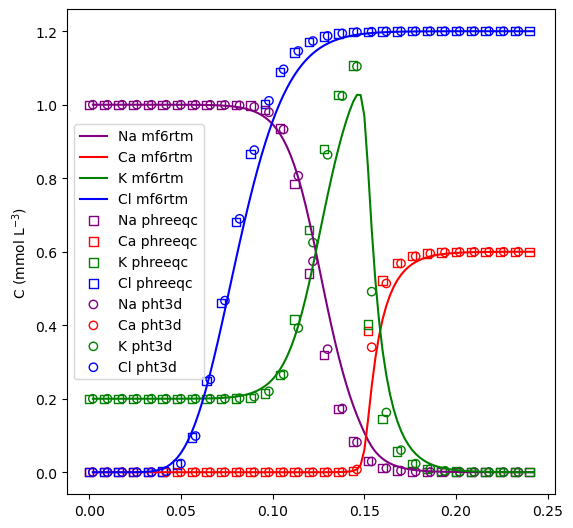

In [12]:
pncol=2
variables = list(simapi.iloc[:,1:-1 ].columns) #dissolved only

pnrow = calc_rows_from_ncol(variables, pncol)

mf6df = simapi[simapi['cell'] == simapi['cell'].max()].copy()
pht3df = simdf[simdf['cell'] == simdf['cell'].max()].copy()
phreeqdf = phreeqcout[phreeqcout['cell'] == phreeqcout['cell'].max()].copy()

colors = ['purple', 'r', 'g', 'b']

fig, axs = plt.subplots(1,1, figsize = (6.3, 6.3))
ax = axs
[ax.plot(mf6df.index, mf6df.loc[:, var]*1000, label = f"{var} mf6rtm", c = colors[variables.index(var)]) for var in variables];
[ax.scatter(phreeqdf.time_d[::4], phreeqdf.loc[:, var][::4]*1000, label = f"{var} phreeqc",  marker = 's',facecolor = 'None', edgecolors = colors[variables.index(var)]) for var in variables];
[ax.scatter(pht3df.index[::4], pht3df.loc[:, var][::4]*1000, label = f"{var} pht3d",  facecolor = 'None', edgecolors = colors[variables.index(var)]) for var in variables];

ax.set_ylabel('C (mmol L$^{-3}$)')

ax.legend()

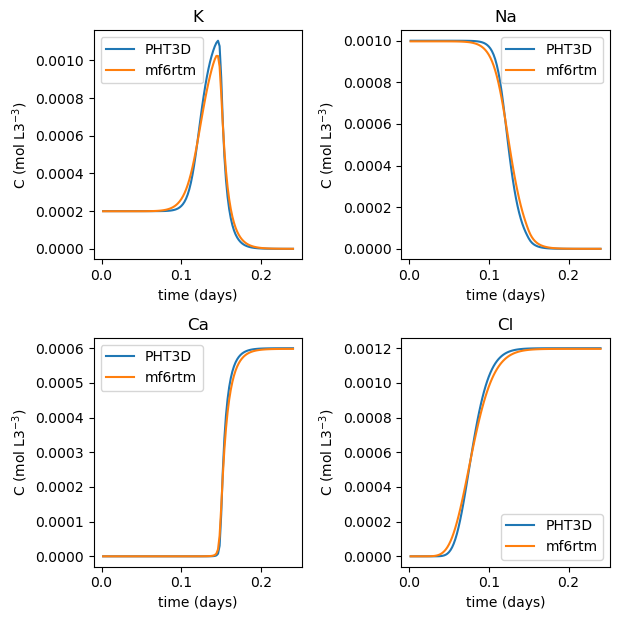

In [13]:
#get common keys from ucndic and ucndic_mf6
common_keys = set(ucndic.keys()).intersection(ucndic_mf6.keys())
common_keys

pncol=2
variables = common_keys

pnrow = calc_rows_from_ncol(variables, pncol)



fig, axs = plt.subplots(pnrow,pncol, figsize = (6.3, 6.3))
for var, ax in zip(common_keys, axs.flatten()):
    ax.plot([x for x in timespht3d], ucndic[var][:,0,0,-1], label = f'PHT3D')
    ax.plot([x for x in times[:]], ucndic_mf6[var][:,0,0,-1]/1000, label = f'mf6rtm')

    #get min and max of y axis
    xmin, xmax = ax.get_ylim()
    # ax.set_ylim(xmin*.8, xmax*1.2)

    ax.set_xlabel('time (days)')
    if var not in ['pH', 'pe']:
        ax.set_ylabel('C (mol L3$^{-3}$)')
    ax.set_title(f'{var}')
    ax.ticklabel_format(useOffset=False)
    ax.legend()
fig.tight_layout()